# BT Neural Network for option price in BS model

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from scipy.stats import norm

## MyIBT_CRR
Implied Binomial Tree - Cox-Ross-Rubinstein is a Python class that implements an implied binomial tree model for option pricing. This model extends the classical CRR binomial tree by allowing state-dependent volatility through a user-defined function, making it particularly useful for pricing options under more realistic market conditions where volatility depends on both asset price and time.

In [170]:
class MyIBT_CRR():
    def __init__(self, n):
        self.n     = n # number of levels
        self.S_    = np.zeros(shape=(int((n+1)*(n+2)/2),),dtype=np.float32)
        self.q_    = np.zeros(shape=(int((n+1)*(n+2)/2),),dtype=np.float32)
        self.V_    = np.zeros(shape=(int((n+1)*(n+2)/2),),dtype=np.float32)

    def _set_S(self, i, j, val):
        self.S_[int(i*(i + 1)/2) + j] = val

    def _get_S(self, i, j):
        return self.S_[int(i*(i + 1)/2) + j]

    def _set_q(self, i, j, val):
        self.q_[int(i*(i + 1)/2) + j] = val

    def _get_q(self, i, j):
        return self.q_[int(i*(i + 1)/2) + j]

    def _set_V(self, i, j, val):
        self.V_[int(i*(i + 1)/2) + j] = val

    def _get_V(self, i, j):
        return self.V_[int(i*(i + 1)/2) + j]

    def build(self, S0, t0, T, r, sigma, teta):
        self.S0    = S0    # current price
        self.t0    = t0    # current time
        self.T     = T     # maturity time
        self.r     = r     # interest rate
        self.sigma = sigma # volatility function (constant)

        dt = (T - t0)/self.n
        sqdt = np.sqrt(dt)

        # starting from even levels, identified by k
        for k in range((self.n // 2) + 1):
            # central node on even levels
            self._set_S(2*k, k, S0)

            for j in range(1, self.n - 2*k + 1): # 2*k+j<=n
                t_ = t0 + (2*k+j-1)*dt
                self._set_S(2*k+j, k,  self._get_S(2*k+j-1, k)*
                           np.exp(-sigma(self._get_S(2*k+j-1, k), t_, teta)*sqdt))
                self._set_S(2*k+j, k+j, self._get_S(2*k+j-1, k+j-1)*
                           np.exp(sigma(self._get_S(2*k+j-1, k+j-1), t_, teta)*sqdt))

        # The probabilities of transition from node (i,j) to node (i+1,j+1)
        for i in range(self.n):
            for j in range(i+1):
                self._set_q(i, j, (self._get_S(i, j)*np.exp(r*dt)-self._get_S(i+1, j))/
                          (self._get_S(i+1, j+1)-self._get_S(i+1, j))
                )

    def eval_european_call(self, K):
        # K is strike-price of a European call option
        dt = (self.T - self.t0)/self.n

        # option values at expiration
        for j in range(self.n + 1):
            self._set_V(self.n, j, max(self._get_S(self.n, j) - K, 0))

        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._set_V(i, j, np.exp(-self.r*dt)*(
                    self._get_V(i + 1, j + 1)*self._get_q(i, j) + 
                    self._get_V(i + 1, j)*(1 - self._get_q(i, j))
                ))

        return self._getV(0, 0)

    def eval_americal_call(self, K):
        # K is strike-price of an American call option
        dt = (self.T - self.t0)/self.n

        # option values at expiration
        for j in range(self.n + 1):
            self._set_V(self.n, j, max(self._get_S(self.n, j) - K, 0))

        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._set_V(i, j, max(np.exp(-self.r*dt)*(
                    self._get_V(i + 1, j + 1)*self._get_q(i, j) + 
                    self._get_V(i + 1, j)*(1 - self._get_q(i, j))
                ),  self._get_S(i, j) - K))

        return self._get_V(0, 0)

    def eval_european_put(self, K):
        # K is strike-price of a European put option
        dt = (self.T - self.t0)/self.n

        # option values at expiration
        for j in range(self.n + 1):
            self._set_V(self.n, j, max(K - self._get_S(self.n, j), 0))

        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._set_V(i, j, np.exp(-self.r*dt)*(
                    self._get_V(i + 1, j + 1)*self._get_q(i, j) + 
                    self._get_V(i + 1, j)*(1 - self._get_q(i, j))
                ))

        return self._get_V(0, 0)

    def eval_american_put(self, K):
        # K is strike-price of an American put option
        dt = (self.T - self.t0)/self.n

        # option values at expiration
        for j in range(self.n + 1):
            self._set_V(self.n, j, max(K - self._get_S(self.n, j), 0))

        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._set_V(i, j, max(np.exp(-self.r*dt)*(
                    self._get_V(i + 1, j + 1)*self._get_q(i, j) + 
                    self._get_V(i + 1, j)*(1 - self._get_q(i, j))
                ), K - self._get_S(i, j)))

        return self._get_V(0, 0)

    def plot(self):
        # plot Sij on plane (t,S)
        x_lst = []
        y_lst = []
        dt = (self.T - self.t0)/self.n
        for i in range(self.n):
            t_ = self.t0 + (i-1)*dt
            for j in range(i+1):
                x_lst.append(t_)
                y_lst.append(self._getS(i, j))

        plt.figure()
        plt.figure(figsize = (8,6))

        plt.scatter(x_lst, y_lst, c="red")

        # plot options
        plt.title("IBT Nodes", fontsize=20)
        plt.ylabel(r"Price $S$", fontsize=15, labelpad=10)
        plt.xlabel(r"Time $t$", fontsize=15, labelpad=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

    @property
    def min(self):
        return self._get_S(self.n, 0)

    @property
    def max(self):
        return self._get_S(self.n, self.n)

## Convolutional Layer

In [173]:
class ConvLayer(nn.Module):
    def __init__(self, filter_weight=None):
        super(ConvLayer, self).__init__()

        self._conv_1d = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=2,
            bias=False
        )

        if filter_weight is not None:
            with torch.no_grad():
                self._conv_1d.weight.data = torch.as_tensor(
                    filter_weight.reshape(1, 1, 2),
                    dtype=torch.float32
                )

    def forward(self, X):
        X = X.unsqueeze(1)

        X = self._conv_1d(X)

        X = X.squeeze(1)
        
        return X

## Dense Layer

In [172]:
class DenseLayer(nn.Module):
    def __init__(self, input_dim, output_dim, W=None, bias = None, transformation=None):
        super(DenseLayer, self).__init__()

        self._linear = nn.Linear(
            in_features=input_dim,
            out_features=output_dim,
            bias=True
        )

        if W is not None:
            with torch.no_grad():
                if isinstance(W, np.ndarray):
                    W = torch.as_tensor(
                        data=W,
                        dtype=torch.float32,
                    )
                if W.dim() == 1:
                    W = W.unsqueeze(0)

                self._linear.weight.data = W.T if W.shape[0] == input_dim else W

        if bias is not None:
            with torch.no_grad():
                if isinstance(bias, np.ndarray):
                    bias = torch.as_tensor(
                        data=bias,
                        dtype=torch.float32
                    )
                self._linear.bias.data = bias.flatten()

        self._transformation = lambda x: x
        if transformation is not None:
            self._transformation = transformation

    def forward(self, X):
        out = self._linear(X)

        out = self._transformation(out)

        return out

## Neural network architecture with BT

In [110]:
class BTNetEuropean(nn.Module):
    def __init__(self, n_dim, S0, sig, T, t0, r = None):
        super(BTNetEuropean, self).__init__()

        self._n_dim = n_dim
        self._S0 = S0
        self._sig = sig
        self._T = T
        self._t0 = t0
        self._r = r if r is not None else 0.05

        dt = (T - t0) / n_dim
        sqrt_dt = np.sqrt(dt)

        u = np.exp(sig * sqrt_dt)
        d = np.exp(-sig * sqrt_dt)

        W = np.array(
            [
                (np.exp(-self._r * dt) * u - 1 ) / (u - d),
                (1 - np.exp(-self._r * dt) * d) / (u - d)
            ],
            dtype=np.float32,
        )

        # Initial Layer
        W_init = np.ones((1, n_dim+1), dtype=np.float32)
        b_init = np.array(
            [
                -S0 * np.exp(sig * sqrt_dt * (2 * j - n_dim))
                for j in range(n_dim+1)
            ],
            dtype=np.float32
        )

        self._initial_layer = DenseLayer(
            input_dim=1,
            output_dim=n_dim + 1,
            W=W_init,
            bias=b_init,
            transformation=torch.relu
        )

        # Convolutional Layer
        self._conv_layer = ConvLayer(filter_weight=W)

        # Dimensions for Forward Pass
        self._dimensions = [n_dim + 1 - i for i in range(n_dim + 1)]

    def forward(self, K):
        if K.dim() == 1:
            K = K.unsqueeze(1)
        elif K.dim() == 2 and K.size(1) != 1:
            K = K[:, :1]

        K = K.float()

        X = self._initial_layer(K)

        for i in range(self._n_dim):
            X = self._conv_layer(X)
            # print(f"Layer {i}: X shape = {X.shape}")

        if X.dim() == 2 and X.size(1) == 1:
            return X.squeeze(1)
        elif X.dim() == 2 and X.size(1) > 1:
            return X.mean(dim=1, keepdim=True)
        else:
            return X.unsqueeze(1) if X.dim() == 1 else X

    def predict(self, K):
        self.eval()

        with torch.no_grad():
            if isinstance(K, np.ndarray):
                K = torch.from_numpy(K).float()
            elif not isinstance(K, torch.Tensor):
                K = torch.tensor(K, dtype=torch.float32)

            if K.dim() == 1:
                K = K.unsqueeze(1)
            elif K.dim() == 2 and K.size(1) != 1:
                K = K[:, :1]

            outputs = self.forward(K)

        return outputs.cpu().numpy()

## Maxout Layer

In [174]:
class MaxoutLayer(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        filter_weight=None,
        W_linear=None,
        bias=None
    ):
        super(MaxoutLayer, self).__init__()

        self._conv_1d = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=2,
            bias=False
        )

        self._linear = nn.Linear(
            in_features=1,
            out_features=output_dim,
            bias=True
        )

        if filter_weight is not None:
            with torch.no_grad():
                self._conv_1d.weight.data = torch.as_tensor(
                    data=filter_weight.reshape(1, 1, 2),
                    dtype=torch.float32
                )

        if W_linear is not None:
            with torch.no_grad():
                if isinstance(W_linear, np.ndarray):
                    W_linear = torch.as_tensor(W_linear, dtype=torch.float32)
                if W_linear.dim() == 1:
                    W_linear = W_linear.unsqueeze(0)

                self._linear.weight.data = W_linear.T

        if bias is not None:
            with torch.no_grad():
                if isinstance(bias, np.ndarray):
                    bias = torch.as_tensor(bias, dtype=torch.float32)

                self._linear.bias.data = bias.flatten()

    def forward(self, V_prev, K):
        V_conv = V_prev.unsqueeze(1)

        V_conv = self._conv_1d(V_conv)

        V_conv = V_conv.squeeze(1)

        V_linear = self._linear(K)

        V_out = torch.max(V_conv, V_linear)

        return V_out

## BTNet for American Options

In [175]:
class BTNetAmerican(nn.Module):
    def __init__(self, n_dim, S0, sig, T, t0, r = None):
        super(BTNetAmerican, self).__init__()

        self._n_dim = n_dim
        self._S0 = S0
        self._sig = sig
        self._T = T
        self._t0 = t0
        self._r = r if r is not None else 0.05

        dt = (T - t0) / n_dim
        sqrt_dt = np.sqrt(dt)

        u = np.exp(sig * sqrt_dt)
        d = np.exp(-sig * sqrt_dt)
        
        self._W = np.array(
            [
                (np.exp(-self._r * dt) * u - 1) / (u - d),
                (1 - np.exp(-self._r * dt) * d) / (u - d)
            ],
            dtype=np.float32
        )

        W_init = np.ones((1, n_dim + 1), dtype=np.float32)
        b_init = np.array(
            [
                -S0 * np.exp(sig * sqrt_dt * (2 * j - n_dim))
                for j in range(n_dim + 1)
            ],
            dtype=np.float32
        )

        self._initial_layer = DenseLayer(
            input_dim=1,
            output_dim=n_dim + 1,
            W=W_init,
            bias=b_init,
            transformation=torch.relu
        )

        self._maxout_layers = nn.ModuleList()
        for i in range(n_dim):
            input_dim = n_dim + 1 - i
            output_dim = n_dim - i

            W_linear = np.ones((1, output_dim), dtype=np.float32)
            b_linear = np.array(
                [
                    -S0 * np.exp(sig * sqrt_dt * (2*j - i))
                    for j in range(output_dim)
                ],
                dtype=np.float32
            )

            self._maxout_layers.append(
                MaxoutLayer(
                    input_dim=input_dim,
                    output_dim=output_dim,
                    filter_weight=self._W,
                    W_linear=W_linear,
                    bias=b_linear
                )
            )

    def forward(self, K):
        if K.dim() == 1:
            K = K.unsqueeze(1)
        elif K.dim() == 2 and K.size(1) != 1:
            K = K[:, :1]

        K = K.float()
        batch_size = K.size(0)

        V = self._initial_layer(K)

        for i, maxout_layer in enumerate(self._maxout_layers):
            V = maxout_layer(V, K)

        if V.dim() == 2 and V.size(1) == 1:
            return V
        else:
            return V.view(batch_size, -1)[:, :1]

    def predict(self, K):
        self.eval()

        with torch.no_grad():
            if isinstance(K, np.ndarray):
                K = torch.from_numpy(K).float()
            elif not isinstance(K, torch.Tensor):
                K = torch.tensor(K, dtype=torch.float32)

            if K.dim() == 1:
                K = K.unsqueeze(1)
            elif K.dim() == 2 and K.size(1) != 1:
                K = K[:, :1]

            outputs = self.forward(K)

            return outputs.cpu().numpy()

## Train

### Train function for the BTNet

In [176]:
def train_BTNet(model, K_train, prices_train, epochs=200, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_fn = nn.MSELoss()

    if isinstance(K_train, np.ndarray):
        K_train = torch.from_numpy(K_train).float()
    if isinstance(prices_train, np.ndarray):
        prices_train = torch.from_numpy(prices_train).float()

    if K_train.dim() == 1:
        K_train = K_train.unsqueeze(1)
    if prices_train.dim() == 1:
        prices_train = prices_train.unsqueeze(1)

    loss_history = []

    for epoch in tqdm(range(epochs)):
        model.train()

        optimizer.zero_grad()

        predictions = model(K_train)

        if predictions.shape != prices_train.shape:
            predictions = predictions.view_as(prices_train)

        # Evaluate Loss
        loss = loss_fn(predictions, prices_train)

        # Backward Pass
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

    return loss_history

## Black-Scholes Put price function 

In [177]:
def bs_put_price(S, K, T, r, sigma):
    d1 = (
        np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T)
    )
    d2 = d1 - sigma * np.sqrt(T)

    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

## Black-Scholes American Put Prices Binomial

In [179]:
def american_put_prices_binomial(S0, K, T, r, sigma, n=100):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    S = np.zeros(n + 1)
    for j in range(n + 1):
        S[j] = S0 * (u ** j) * (d ** (n-j))

    V = np.maximum(K-S, 0)

    for i in range(n-1, -1, -1):
        for j in range(i + 1):
            S_ij = S0 * (u ** j) * (d ** (i - j))
            V[j] = max(
                K - S_ij, # Early exit 
                discount * (p * V[j+1] + (1 - p) * V[j]) # Hold
            )

    return V[0]

### Plot functions

In [180]:
def plot_comparison(K, bs_prices, nn_prices, title="Option Price Comparison"):
    plt.figure(figsize=(10,6))

    K = np.array(K).flatten()
    bs_prices = np.array(bs_prices).flatten()
    nn_prices = np.array(nn_prices).flatten()

    plt.plot(K, bs_prices, 'b--', label = 'Black-Scholes' )
    plt.plot(K, nn_prices, 'r--', label = 'BTNet' )

    plt.xlabel('Strike Price K')
    plt.ylabel('Option Price')

    plt.legend()

    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [181]:
def plot_errors(K, bs_prices, nn_prices, title="Prediction Errors"):
    plt.figure(figsize=(10, 6))

    K = np.array(K).flatten()
    bs_prices = np.array(bs_prices).flatten()
    nn_prices = np.array(nn_prices).flatten()

    errors = nn_prices - bs_prices

    plt.plot(K, errors, 'g-', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.xlabel('Strike Price K')
    plt.ylabel('Error (NN - BS)')

    plt.title(title)

    plt.grid(True, alpha=0.3)

    plt.show()

    print(f"Mean Absolute Error: {np.mean(np.abs(errors)):.6f}")
    print(f"Root Mean Square Error: {np.sqrt(np.mean(errors**2)):.6f}")

In [182]:
def plot_training_losses(loss_hist_euro, loss_hist_amer, title="Training Losses"):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_hist_euro, 'b-', linewidth=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('European Model Training Loss')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss_hist_amer, 'r-', linewidth=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('American Model Training Loss')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

## Test

In [183]:
# The paper parameters
S0 = 0.5
t0 = 0.0
T = 1.0
r = 0.05
sig = 0.25
n_dim = 9 # periods

# Generate Train
K_min, K_max = 0.25, 0.75
nK = 500

# Sample
K_samples = np.random.uniform(K_min, K_max, nK).reshape(-1, 1)
K_test = np.linspace(K_min, K_max, 51).reshape(-1, 1)

### Test European Put Option

In [184]:
prices_euro = bs_put_price(S0, K_samples, T, r, sig).reshape(-1, 1)

model_european = BTNetEuropean(n_dim, S0, sig, T, t0, r)

loss_hist_european = train_BTNet(
    model=model_european,
    K_train=K_samples,
    prices_train=prices_euro,
    epochs=200,
    lr=0.01
)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [50/200], Loss: 0.000001
Epoch [100/200], Loss: 0.000000
Epoch [150/200], Loss: 0.000000
Epoch [200/200], Loss: 0.000000


In [186]:
predictions_euro = model_european.predict(K_test)
true_prices = bs_put_price(S0, K_test, T, r, sig)

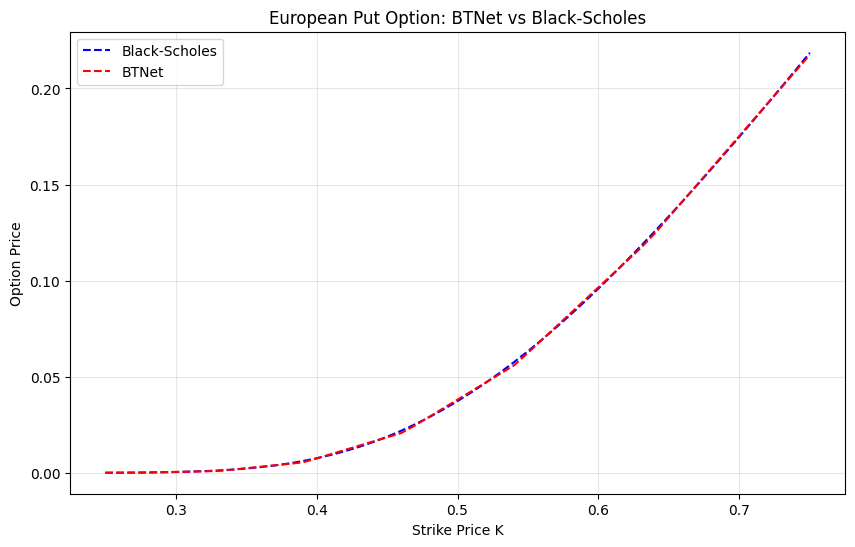

In [187]:
plot_comparison(
    K=K_test,
    bs_prices=true_prices,
    nn_prices=predictions_euro,
    title="European Put Option: BTNet vs Black-Scholes"
)

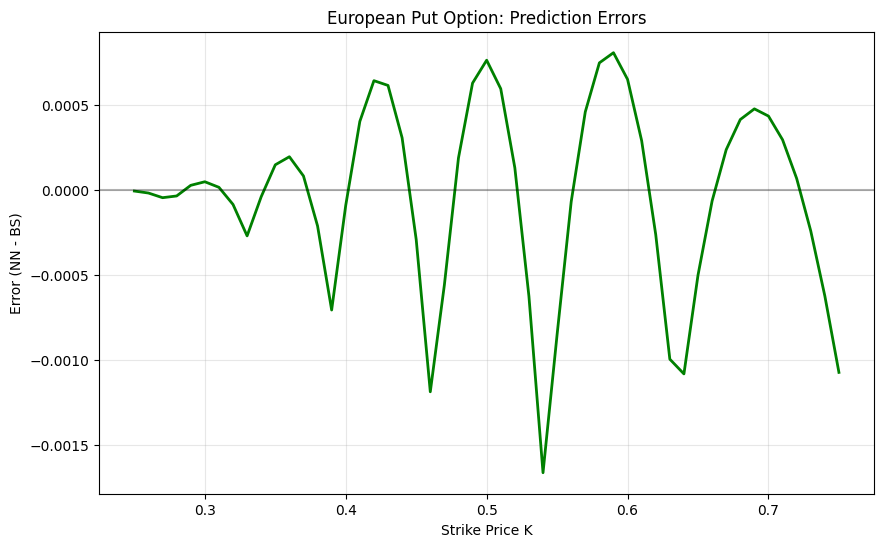

Mean Absolute Error: 0.000417
Root Mean Square Error: 0.000553


In [188]:
plot_errors(
    K = K_test,
    bs_prices=true_prices,
    nn_prices=predictions_euro,
    title = "European Put Option: Prediction Errors"
)

### Test American Put Option

In [189]:
prices_american = np.array(
    [
        american_put_prices_binomial(
            S0=S0,
            K=K,
            T=T,
            r=r,
            sigma=sig,
            n=100
        )
        for K in K_samples.flatten()
    ]
).reshape(-1, 1)

In [190]:
model_american = BTNetAmerican(
    n_dim=n_dim,
    S0=S0,
    sig=sig,
    T=T,
    t0=t0,
    r=r
)

loss_hist_american = train_BTNet(
    model=model_american,
    K_train=K_samples,
    prices_train=prices_american,
    epochs=200,
    lr=0.01
)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [50/200], Loss: 0.000543
Epoch [100/200], Loss: 0.000032
Epoch [150/200], Loss: 0.000002
Epoch [200/200], Loss: 0.000001


In [191]:
predictions_american = model_american.predict(K_test).flatten()
true_prices_american = np.array(
    [
        american_put_prices_binomial(
            S0=S0,
            K=K,
            T=T,
            r=r,
            sigma=sig,
            n=100
        )
        for K in K_test.flatten()
    ]
)

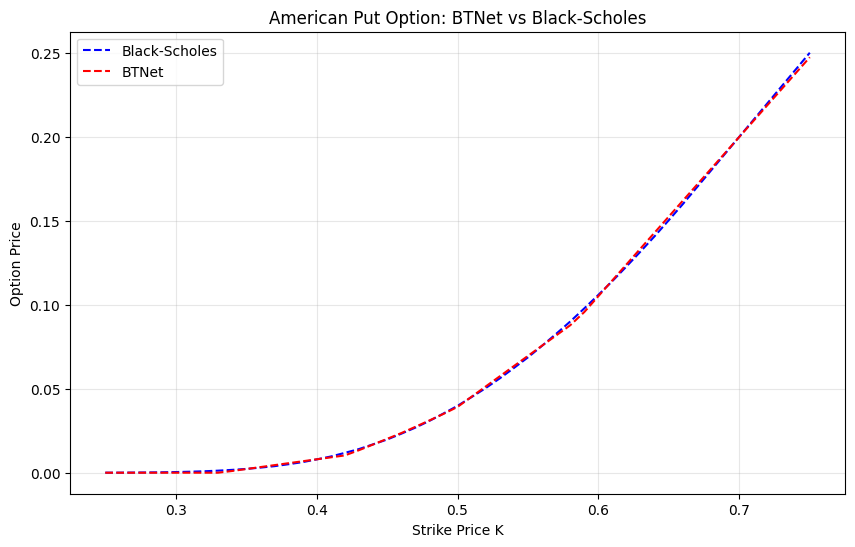

In [192]:
plot_comparison(
    K=K_test,
    bs_prices=true_prices_american,
    nn_prices=predictions_american,
    title="American Put Option: BTNet vs Black-Scholes"
)

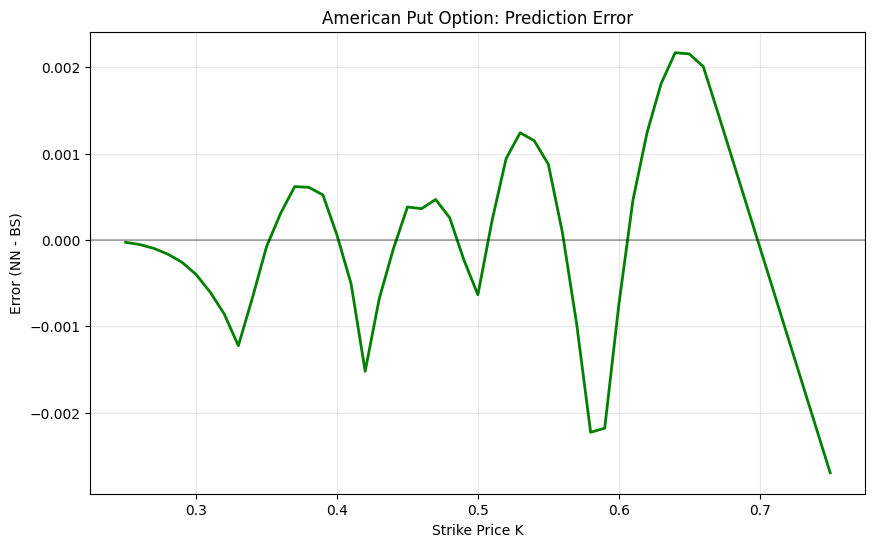

Mean Absolute Error: 0.000851
Root Mean Square Error: 0.001106


In [193]:
plot_errors(
    K=K_test,
    bs_prices=true_prices_american,
    nn_prices=predictions_american,
    title="American Put Option: Prediction Error"
)

## Training Losses: European and American

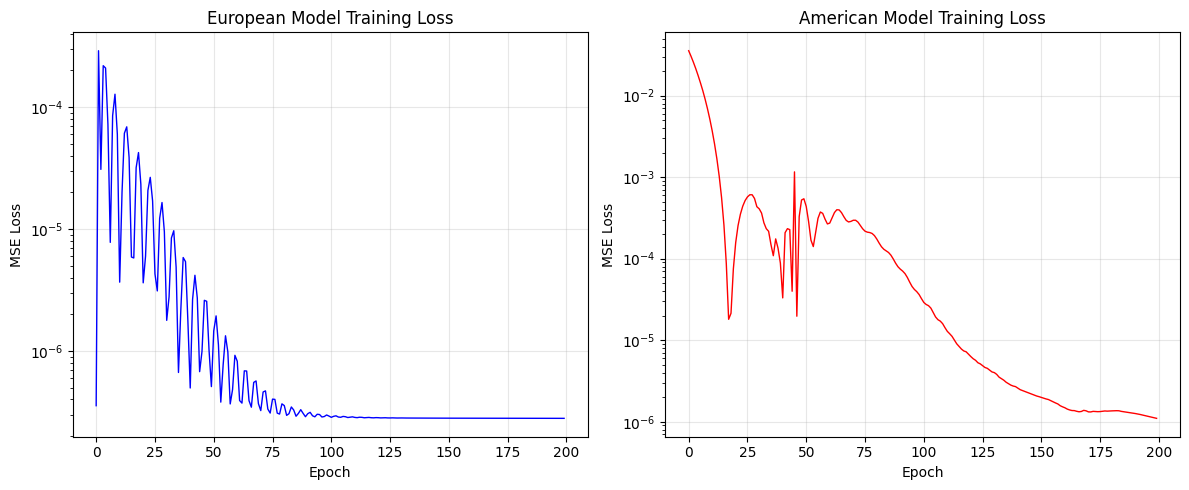

In [194]:
plot_training_losses(
    loss_hist_euro=loss_hist_european,
    loss_hist_amer=loss_hist_american
)